# Deep Learning - Training a Simple Convolution Neural Network Model

Found 4665 images belonging to 10 classes.
Found 1542 images belonging to 10 classes.
Epoch 1/20
146/146 [==============================] - 2997s 21s/step - loss: 0.8114 - accuracy: 0.7269 - val_loss: 0.2829 - val_accuracy: 0.8995
Epoch 2/20
146/146 [==============================] - 54s 368ms/step - loss: 0.0866 - accuracy: 0.9676 - val_loss: 0.1882 - val_accuracy: 0.9397
Epoch 3/20
146/146 [==============================] - 54s 366ms/step - loss: 0.0313 - accuracy: 0.9927 - val_loss: 0.0659 - val_accuracy: 0.9780
Epoch 4/20
146/146 [==============================] - 54s 368ms/step - loss: 0.0067 - accuracy: 0.9996 - val_loss: 0.0975 - val_accuracy: 0.9572
Epoch 5/20
146/146 [==============================] - 51s 347ms/step - loss: 0.0035 - accuracy: 0.9996 - val_loss: 0.2096 - val_accuracy: 0.9228
Epoch 6/20
146/146 [==============================] - 52s 354ms/step - loss: 0.0045 - accuracy: 0.9987 - val_loss: 0.0972 - val_accuracy: 0.9669
Epoch 7/20
146/146 [========================

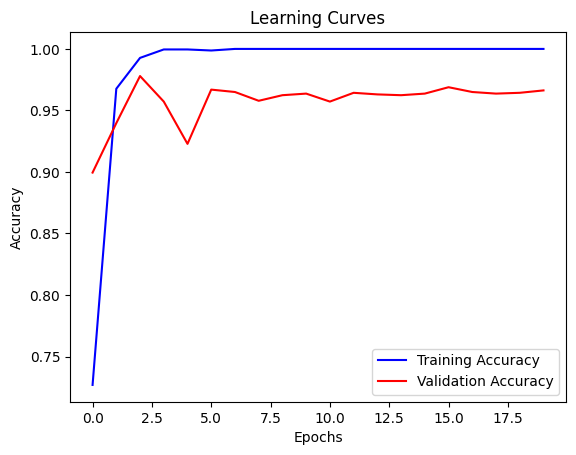

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

# Step 1: Define image dimensions, batch size, and directory paths
image_height = 100
image_width = 100
batch_size = 32

train_dir = '/content/drive/MyDrive/TrainingImages/'
test_dir = '/content/drive/MyDrive/TestingImages/'

# Step 2: Data generators for training and testing
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Step 3: Define the model architecture
model = Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    Conv2D(8, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(10, activation='softmax')
])

# Step 4: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Train the model
history = model.fit(train_generator,
                    epochs=20,
                    validation_data=test_generator)

# Step 6(a): Plot learning curves
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


# Transfer Learning via Feature Extraction

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Step 1: Define configuration variables
image_height = 224  # Modified image height
image_width = 224  # Modified image width
batch_size = 32
num_classes = 10
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Load the dataset using ImageDataLoader and organize it on disk
train_dir = "/content/drive/MyDrive/TrainingImages/"
test_dir = "/content/drive/MyDrive/TestingImages/"

train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_height, image_width)),
        torchvision.transforms.ToTensor(),
    ])
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_height, image_width)),
        torchvision.transforms.ToTensor(),
    ])
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Step 3: Build the model (transfer learning via feature extraction)
resnet18 = torchvision.models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)
resnet18 = resnet18.to(device)

# Step 4: Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []  # Store accuracies

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train, total_train = 0, 0
    resnet18.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Accuracy calculation
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)  # Append train accuracy

    # Evaluation on test set
    resnet18.eval()
    correct_test, total_test = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)  # Append test accuracy
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))

    print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
          "Training Accuracy: {:.3f}.. ".format(train_accuracy),
          "Test Accuracy: {:.3f}".format(test_accuracy))

# Step 5: Plot learning curves
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show


# Step 6: Extract features from ResNet18 for training and test datasets
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.features = None
        self.hook = self.model.layer4.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output

    def extract(self, x):
        self.model(x)
        return self.features

train_feature_extractor = FeatureExtractor(resnet18)
test_feature_extractor = FeatureExtractor(resnet18)

train_features = []
train_labels = []

test_features = []
test_labels = []

# Extract features and labels from the training dataset
for images, labels in train_loader:
    features_batch = train_feature_extractor.extract(images.to(device))
    train_features.append(features_batch.detach().cpu().numpy())
    train_labels.append(labels.numpy())

# Extract features and labels from the test dataset
for images, labels in test_loader:
    features_batch = test_feature_extractor.extract(images.to(device))
    test_features.append(features_batch.detach().cpu().numpy())
    test_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)
test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)

# Step 7: Perform PCA dimensionality reduction
pca = PCA(n_components=2)

# Flatten the features
train_features_flattened = train_features.reshape(train_features.shape[0], -1)
test_features_flattened = test_features.reshape(test_features.shape[0], -1)

# Apply PCA transformation
train_features_pca = pca.fit_transform(train_features_flattened)
test_features_pca = pca.transform(test_features_flattened)

# Step 8: Train SVM prediction model using extracted features
svm_model = SVC(kernel='rbf', C=10)
svm_model.fit(train_features_pca, train_labels)

# Step 9: Evaluate SVM model
train_predictions = svm_model.predict(train_features_pca)
test_predictions = svm_model.predict(test_features_pca)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print("SVM Training Accuracy (after PCA):", train_accuracy)
print("SVM Test Accuracy (after PCA):", test_accuracy)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 138MB/s]


#Transfer Learning via Fine-Tuning


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Define configuration variables
image_height = 224  # Modified image height
image_width = 224  # Modified image width
batch_size = 32
num_classes = 10
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Step 2: Load the dataset using ImageDataLoader and organize it on disk
train_dir = "/content/drive/MyDrive/TrainingImages/"
test_dir = "/content/drive/MyDrive/TestingImages/"

train_dataset = torchvision.datasets.ImageFolder(
    root=train_dir,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_height, image_width)),
        torchvision.transforms.ToTensor(),
    ])
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_dir,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_height, image_width)),
        torchvision.transforms.ToTensor(),
    ])
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Step 3: Build the model (fine-tuning)
resnet18 = torchvision.models.resnet18(weights=None)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes).to(device)
resnet18 = resnet18.to(device)

# Step 4: Train the model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.001)

train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    resnet18.train()
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    resnet18.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)

    print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
          "Training Accuracy: {:.3f}.. ".format(train_accuracy),
          "Test Accuracy: {:.3f}".format(test_accuracy))

# Step 5: Plot learning curves
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()
